In [579]:
import pandas as pd
import numpy as np
import warnings
import time
import matplotlib.pyplot as plt

# one file read three times, can be optimized
m_lt = pd.read_excel('gorilla_test_data.xlsx', sheet_name='meter_list')
ft = pd.read_excel('gorilla_test_data.xlsx', sheet_name='forecast_table')
rate = pd.read_excel('gorilla_test_data.xlsx', sheet_name='rate_table')

# filling missing values in the table
rate.loc[np.isnan(rate["aq_max_kwh"]), 'aq_max_kwh'] = np.inf


# Problem 1
First function created with for loops to understand the provided dataset. Later vectorized operations were created to solve the problem.

In [580]:
# def calculate_cost_energy(m_lt, ft):
#     """
#     Calculate total consumption and the cost of meter in the forcast period

#     Parameters:
#     m_lt (pd.DataFrame): meter_list in the given dataset
#     ft (pd.DataFrame): forecast_table in the given dataset
#     Returns:
#     pd.DataFrame: table containing Total_consumption and cost of the given meter
#     """
#     meter_energy = pd.DataFrame({"Meter":[], 
#                             "Total_Consumption":[],
#                             "Cost":[]})
    
#     k = -1
#     kwh_sum = []
#     cost_sum = []
    
    
#     ft['rates'] = 0
#     ft_gr = ft.groupby('meter_id')
#     # find the upper limit of max. days according to rate_table
#     ed = pd.DataFrame({0:['2021-04-01','2021-10-01']})
#     ed[0] = pd.to_datetime(ed[0])
#     days_lim = (ed[0][1] - ed[0][0]) / np.timedelta64(1, 'D')
    
    
#     for name, group in ft_gr:
#         k += 1
#         i = 0
#         exit_zone = m_lt['exit_zone'].iloc[k]
#         aq = m_lt['aq_kwh'].iloc[k]

#         indices = group.index
#         print('\n',group)

#         for ft_date in group['date']:

#             if rate['date'].iloc[-1]>=group['date'][indices[i]]:


#                 cp = rate[(rate['exit_zone']==exit_zone)
#                           *(group['date'][indices[i]]>= rate['date'])
#                           *((group['date'][indices[i]] - rate['date'])/ np.timedelta64(1, 'D') < days_lim)].index.values

#                 ac_index = [cp[j] for j in range(len(cp)) if rate['aq_min_kwh'][cp[j]] <= aq <= rate['aq_max_kwh'][cp[j]]]
# #                 print('\n',ac_index)
# #                 print(cp, 'cp \n')
# #                 print(group['date'][indices[i]], 'forcast_date\n')
# #                 group.loc[indices[i], 'rates'] = rate['rate_p_per_kwh'].iloc[ac_index[-1]]
#                 group['rates'].loc[indices[i]] = rate['rate_p_per_kwh'].iloc[ac_index[-1]]
    
#                 i+=1



#             else:
#                 break

#         kwh_sum.append(sum(group['kwh']))
#         cost_sum.append(sum(group["kwh"]*group['rates']*0.01))

#     meter_energy["Meter"] =  m_lt['meter_id']
#     meter_energy["Total_Consumption"] = kwh_sum
#     meter_energy["Cost"] = cost_sum

#     return meter_energy 



        
   
    

## Assumptions 
### Valid for the whole assesment
    1. Exit zones are assumed to be in same order for each date in the rate_table.
    2. Number of energy bands with  min and max energy values are assumed to be uniform across meters.
    3. Time duration of forcast and start_date in rate_table are assumed to be consistent across meters.


In [581]:
def calculate_cost_energy_optimized(m_lt, ft):
    """
    Calculate total consumption and the cost of meter in the forcast period

    Parameters:
    m_lt (pd.DataFrame): meter_list in the given dataset
    ft (pd.DataFrame): forecast_table in the given dataset
    Returns:
    pd.DataFrame: table containing Total_consumption and cost for the given meters
    """
    meter_energy = pd.DataFrame({"Meter":[], 
                            "Total_Consumption":[],
                            "Cost":[]})


    kwh_sum = []
    cost_sum = []

    nb_days = (ft['date'].iloc[-1] - ft['date'].iloc[0])/np.timedelta64(1, 'D') + 1
    zones = np.unique(rate['exit_zone'])
    size_zones = len(zones)
    nb_bands = 3 # HARDCODED 
    nb_meters = len(m_lt)


    # selecting energy bands in rate_table for each meter and inserting in meter list
    meter_bands = pd.DataFrame({"minp":rate["aq_min_kwh"].iloc[0:nb_bands].values,
                          "maxp":rate["aq_max_kwh"].iloc[0:nb_bands].values})
    s1=meter_bands["minp"].values
    s2=meter_bands["maxp"].values
    s=m_lt.aq_kwh.values[:,None]
    result = np.dot((s>=s1)&(s<s2),np.arange(0,nb_bands, dtype = int))
    m_lt["range"] = result


    
    for i in range(len(m_lt)):
        df_1 = ft.loc[i*(nb_days):(i+1)*(nb_days)-1]
        exit_zone = m_lt['exit_zone'].iloc[i]
        start1_index = np.argwhere(zones == exit_zone)
        start2_index = m_lt['range'].loc[i]
        start_index = start1_index * nb_bands + start2_index
        start_indices = np.arange(start_index, len(rate), size_zones*nb_bands, dtype = int)
        df_LookupTable = pd.DataFrame({'Start': rate['date'].loc[start_indices[:-1]].values,
                                       'Stop': rate['date'].loc[start_indices[1:]].values,
                                       'Rate': rate['rate_p_per_kwh'].loc[start_indices[:-1]].values })

        result = np.dot(
            (df_1['date'].values[:, None] >= df_LookupTable['Start'].values) &
            (df_1['date'].values[:, None] < df_LookupTable['Stop'].values),
            df_LookupTable['Rate'])

        kwh_sum.append(sum(df_1['kwh']))
        cost_sum.append(0.01*np.dot(result,df_1['kwh'].values))


    meter_energy["Meter"] =  m_lt['meter_id']
    meter_energy["Total_Consumption"] = kwh_sum
    meter_energy["Cost"] = cost_sum

    meter_energy = meter_energy.round(2)
    return meter_energy








## Solution 1


In [582]:
# meter_energy = calculate_cost_energy(m_lt, ft)
# print(meter_energy)
meter_energy = calculate_cost_energy_optimized(m_lt, ft)
print(meter_energy)


      Meter  Total_Consumption     Cost
0  14676236            28978.0   100.15
1  34509937            78324.0   275.49
2  50264822           265667.0   731.24
3  88357331           484399.0  1433.16


# Problem 2

In [583]:
def random_meter_list(input_meters, total_zones):
    """
    Generates random meter list with columns in the given meter_list.xlsx

    Parameters:
    input_meters (int)        : number of meters
    total_zones (numpy.array) : array consisting unique value of zones mentioned in rate_table
    Returns:
    pd.DataFrame: table containing randomized meter list with total annual quantity and exit zone
    """
    new_meter_list = pd.DataFrame()
    total_meter_cap = np.random.randint(20000, high=1000000,
                               size=input_meters)
    zone_indices = np.random.randint(0, high=total_zones,
                               size=input_meters)
    meter_names = np.random.randint(20000000,
                               size=input_meters)
    
    new_meter_list['meter_id'] = meter_names
    new_meter_list['aq_kwh'] = total_meter_cap
    new_meter_list['exit_zone'] = zones[zone_indices]
    return new_meter_list
    

## Solution 2

In [584]:
zones = np.unique(rate['exit_zone'])
total_zones = len(zones)
input_meters = 2
new_meter_list = random_meter_list(input_meters, total_zones)
print('\n',new_meter_list)






    meter_id  aq_kwh exit_zone
0  13952417  490548       NW1
1  15023938  594660       WA1


# Problem 3

In [585]:
def random_forcast_table(meter_ids, start_date, end_date):
    """
    Generates random forcast table for all the meters listed in meter_ids for the forcast period given by 
    start and end dates. The start and end dates are uniform for all meters.

    Parameters:
    meter_ids     (numpy array): array containing unique meter ids
    start_date         (string): start date of the forcast period
    end_date           (string): end date of the forcast period
    Returns:
    pd.DataFrame: table containing daily kwh usage per day in forcast table for the given meters
    """
    
    new_forcast_table = pd.DataFrame()
    dates = pd.date_range(start=start_date, end=end_date)
    all_meter = np.array([])
    all_date = []
    all_kwh = np.array([])
    for i in range(len(meter_ids)):
        all_meter = np.append(all_meter, np.ones(len(dates))*meter_ids[i])
        all_date.extend(dates)
        all_kwh = np.append(all_kwh, np.random.normal(50, 3, len(dates)))
        
    new_forcast_table['meter_id'] = all_meter.astype(np.int32)
    new_forcast_table['date'] = all_date
    new_forcast_table['kwh'] = all_kwh
    return new_forcast_table 

## Solution 3

In [586]:
# start date and forcast duration are unoform across all meters (Assumptions part 3)
meter_ids = new_meter_list['meter_id']
start_date = '1/1/2020'
end_date = '1/24/2020'

new_forcast_table = random_forcast_table(meter_ids, start_date, end_date)
print(new_forcast_table)

    meter_id       date        kwh
0   13952417 2020-01-01  55.703768
1   13952417 2020-01-02  50.799026
2   13952417 2020-01-03  52.235946
3   13952417 2020-01-04  49.570627
4   13952417 2020-01-05  53.498634
5   13952417 2020-01-06  52.888783
6   13952417 2020-01-07  50.406873
7   13952417 2020-01-08  49.075801
8   13952417 2020-01-09  50.363574
9   13952417 2020-01-10  46.795396
10  13952417 2020-01-11  48.670146
11  13952417 2020-01-12  57.499108
12  13952417 2020-01-13  50.704338
13  13952417 2020-01-14  44.289746
14  13952417 2020-01-15  47.190035
15  13952417 2020-01-16  57.258203
16  13952417 2020-01-17  45.125063
17  13952417 2020-01-18  51.430233
18  13952417 2020-01-19  54.462408
19  13952417 2020-01-20  47.645828
20  13952417 2020-01-21  53.455994
21  13952417 2020-01-22  48.638742
22  13952417 2020-01-23  52.599335
23  13952417 2020-01-24  54.396478
24  15023938 2020-01-01  48.712889
25  15023938 2020-01-02  48.836208
26  15023938 2020-01-03  49.074693
27  15023938 2020-01

## Solution 4 , part a
Calling all the functions written previously to generate random datasets. The meter numbers, starting date and end date are provided as input values that can be changed by the user.

In [587]:
# The functions are based on assumptions stated under Problem 1
# Exception handle used to check the validity of input dates for forcast with the provided rate table
## 1. end date should be atleast equal latest date in rate_table to calculate transportation cost
## 2. start date should be more than the minimum in the rate table

# Sol 2
total_zones = len(zones)
input_meters = 2
new_meter_list = random_meter_list(input_meters, total_zones)
print(new_meter_list,'\n')

# Sol 3
meter_ids = new_meter_list['meter_id']
start_date = '5/5/2020'
end_date = '10/24/2024'

try:
    new_forcast_table = random_forcast_table(meter_ids, start_date, end_date)
    new_meter_energy = calculate_cost_energy_optimized(new_meter_list, new_forcast_table)
    print(new_meter_energy)
except:
    if (pd.to_datetime(start_date) < rate['date'].iloc[0]) | (pd.to_datetime(end_date) > rate['date'].iloc[-1]):
        print("Invalid dates")
        print("Change the input the dates for calculating the transportation costs")
        







   meter_id  aq_kwh exit_zone
0   2663623  494284       NE3
1  11575718  564537       EA3 

      Meter  Total_Consumption    Cost
0   2663623           81706.47  391.53
1  11575718           81711.20  312.30


## Solution 4, part b

In [588]:
# The functions are based on assumptions stated under Problem 1
# Exception handle used to check the validity of input dates for forcast with the provided rate table
## 1. end date should be atleast equal latest date in rate_table to calculate transportation cost
## 2. start date should be more than the minimum in the rate table
# print commands between time mapping are removed to get better time estimates

# Sol: 2


total_zones = len(zones)
input_meters = np.array([10, 20, 30, 40, 50]) # number of meters
start_date = '5/5/2020'
intervals = [29, 89, 179, 359, 2*359] # number of days
end_date = pd.to_datetime(intervals, unit='D', origin = pd.to_datetime(start_date))
total_meters = len(input_meters)
total_intervals = len(intervals)

# store time spent for each scenario 
time_all = np.empty([total_meters,total_intervals])
start = 0
end = 0
for m in range(len(input_meters)):
    start = time.time()
    new_meter_list = random_meter_list(input_meters[m], total_zones)

    # Sol 3
    meter_ids = new_meter_list['meter_id']
    for date_itr in range(len(end_date)):
        try:
            new_forcast_table = random_forcast_table(meter_ids, start_date, end_date[date_itr])
            new_meter_energy = calculate_cost_energy_optimized(new_meter_list, new_forcast_table)
            
            time_all[m,date_itr] = time.time() - start
        except:
            if (pd.to_datetime(start_date) < rate['date'].iloc[0]) | (pd.to_datetime(end_date[date_itr]) > rate['date'].iloc[-1]):
                print("Change the input the dates for calculating the transportation costs \n")




### Plotting Computation time curve with increasing forcast duration and meters

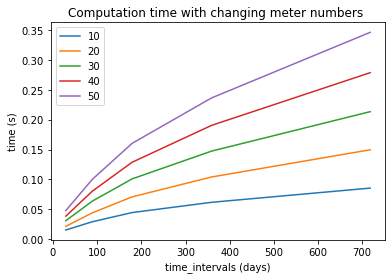

In [589]:
plt.figure()
for m in range(len(input_meters)):
    
    plt.plot(intervals, time_all[m,:])
    plt.xlabel('time_intervals (days)')
    plt.ylabel('time (s)')
    
plt.legend(input_meters)
plt.title('Computation time with changing meter numbers ')
plt.show()


# Solution 5

## Assumptions
1. Exit zones are assumed to be in same order for each date in the rate_table.
2. Number of energy bands with  min and max energy values are assumed to be uniform across meters.
3. Time duration of forcast and start_date in rate_table are assumed to be consistent across meters.
    
### Reading excel files
1. Excel files is read three times for each table. For a sizable dataset it can be read at once.
2. For large datasets with high forcast duration and number of meters, reading data can be optimized using python libraries
    a. Large datasets can be read from cloud. Divinding larges datasets into small chunks increase the data transfer and saves the loaded transfer incase of network interruption. For e.g. First step of sorting the data by exit zone can be done on server and afterwards importing the small files from the server. 


### Computation time
1. The computation graph can be improved by providing average time values over many iterations. This ensures cancelling noise during processing time.
2. Computation time is machine specific. The displayed plot are run on MacOS Monterey, MacBook Air M1 2020, Memory 8GB and chip M1.